Reading Data

In [5]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch

SEQ_LEN = 50
NUM_FEATURES = 4 * 25  # 25 landmarks X 4 features each - x,y,z,vis


def read_raw_data(score_path, data_path):
    shot_names = {}

    score_df = pd.read_csv(score_path)
    score_df = score_df[score_df['frames'] < SEQ_LEN]

    data_df = pd.read_csv(data_path)
    amount_of_shots = len(score_df)
    print('all examples:', amount_of_shots)

    single_shot_x = np.zeros((SEQ_LEN, NUM_FEATURES))
    x = np.zeros((amount_of_shots, SEQ_LEN, NUM_FEATURES))
    y = []
    shot_index = 0

    for _, row in tqdm(score_df.iterrows()):

        frames = row['frames']
        score = row['score']
        shot_name = row['name']

        for i in range(0, frames):
            frame_name = shot_name + '_{}'.format(i)
            shot_data = []
            for k, v in data_df[data_df['name'] == frame_name].iteritems():
                if k == 'name':
                    continue
                shot_data.append(v.values[0])
            single_shot_x[i] = np.array(shot_data)

        if shot_index == amount_of_shots:
            break

        y.append(score)
        x[shot_index] = np.nan_to_num(single_shot_x)
        shot_names[shot_index] = shot_name
        shot_index += 1
    return torch.from_numpy(x).float(), np.array(y), shot_names


# keep x and y unchanged
x, y, names = read_raw_data(score_path='labels/fts_score.csv', data_path='labels/fts_data.csv')

all examples: 1371


0it [00:00, ?it/s]

Feature Selection

In [6]:
def feature_selection(remove_features):
    copy = x.clone() # don't change x
    # TODO - impl
    return copy

#Usage example - remove head landmarks 
head_landmarks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
data = feature_selection(head_landmarks)
print(data.shape)

torch.Size([1371, 50, 100])


Binary scoring

In [7]:
score_threshold = 6
labels = np.array(y)
labels[labels <= score_threshold] = 0
labels[labels > score_threshold] = 1
unique, counts = np.unique(labels, return_counts=True)
for idx, c in enumerate(counts):
    print(f'label: {idx}: {c} samples')

label: 0: 1101 samples
label: 1: 270 samples


Config

In [20]:
## Network 
EMBEDDING_DIM = 18
HIDDEN_DIM = 24
OUTPUT_DIM = 2
BATCH_SIZE = 4
IS_BID = True
NUM_LAYERS = 3

## Optimizer  
lr = 1e-3
weight_decay=0.001

## Scheduler
step_size=3
gamma=0.5

early_stop_patience = 8

Data Set & Loaders

In [16]:
from torch.utils.data import Dataset, DataLoader, random_split

def split_(ratio, dataset):
    major_size = int(ratio * len(dataset))
    minor_size = int((1-ratio) * len(dataset))
    return random_split(dataset, [major_size, minor_size + 1], torch.Generator().manual_seed(42))


class TTDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def create_dataloaders(batch_size):
    dataset_all = TTDataset(data, labels)
    train_data, test_data = split_(0.8, dataset_all)
    train_data, validation_data = split_(0.6, train_data)
    
    print('#train samples: ', len(train_data))
    print('#valid samples: ', len(validation_data))
    print('#test  samples: ', len(test_data))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    return train_loader, validation_loader, test_loader

    
train_loader, validation_loader, test_loader = create_dataloaders(BATCH_SIZE)

#train samples:  657
#valid samples:  439
#test  samples:  275


Learning

In [17]:
import torch.nn as nn
import math

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.scale = 1. / math.sqrt(hidden_size)

    def forward(self, hidden, outputs):
        hidden = hidden.unsqueeze(1)
        values = outputs.transpose(0, 1)
        outputs = outputs.transpose(0, 1).transpose(1, 2)

        weights = torch.bmm(hidden, outputs)
        scores = F.softmax(weights.mul_(self.scale), dim=2)
        linear_combination = torch.bmm(scores, values).squeeze(1)
        return linear_combination


class Network(nn.Module):
    def __init__(self, input_dim, h_dim, out_dim, num_layers=1, bidirectional=True):
        super().__init__()
        self.num_layers = num_layers
        self.h_dim = h_dim
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(0.5)

        # Attention layer - unused so far
        hid_bidirectional = h_dim * 2 if bidirectional else h_dim
        self.atten = Attention(hid_bidirectional)

        # LSTM
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=h_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional, batch_first=True)  # dropout
        # FC layer
        self.fc = nn.Linear(hid_bidirectional, out_dim, bias=True)

        # To convert class scores to log-probability we'll apply log-softmax
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, X):
        lay_times_dir = self.num_layers * 2 if self.bidirectional else self.num_layers
        h0 = torch.zeros(lay_times_dir, BATCH_SIZE, HIDDEN_DIM).to(device)
        c0 = torch.zeros(lay_times_dir, BATCH_SIZE, HIDDEN_DIM).to(device)

        out, (h_t, c_t) = self.lstm(X, (h0, c0))
        if self.bidirectional:
            cell_state = torch.cat([c_t[-1], c_t[-2]], dim=1)
        else:
            cell_state = c_t[-1]

        y = self.fc(cell_state)
        yt_log_proba = self.log_softmax(y)
        return yt_log_proba

In [18]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


epoch 0 | train loss : 0.48118484020233154 validation loss: 0.46587318181991577 
epoch 0 | train acc : 0.8048780487804879 validation acc: 0.8027522935779816 
epoch 1 | train loss : 0.45034441351890564 validation loss: 0.4961286187171936 
epoch 1 | train acc : 0.8048780487804879 validation acc: 0.8027522935779816 
epoch 2 | train loss : 0.4351355731487274 validation loss: 0.45066457986831665 
epoch 2 | train acc : 0.8094512195121951 validation acc: 0.805045871559633 
epoch 3 | train loss : 0.41761770844459534 validation loss: 0.4436914026737213 
epoch 3 | train acc : 0.8140243902439024 validation acc: 0.7912844036697247 
epoch 4 | train loss : 0.4079481065273285 validation loss: 0.44030699133872986 
epoch 4 | train acc : 0.8201219512195121 validation acc: 0.7729357798165137 
epoch 5 | train loss : 0.40577757358551025 validation loss: 0.45510560274124146 
epoch 5 | train acc : 0.8201219512195121 validation acc: 0.7798165137614679 
epoch 6 | train loss : 0.3894626200199127 validation loss

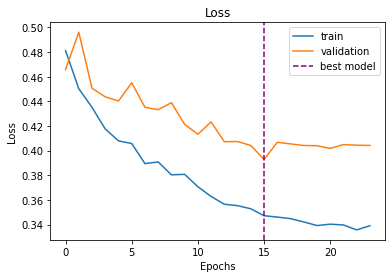

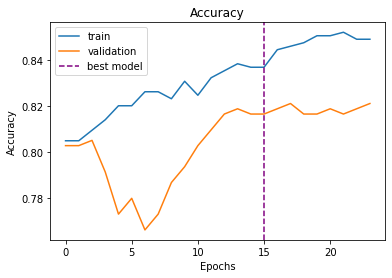

In [21]:
from learning.learn_utils import train_model

model = Network(NUM_FEATURES, HIDDEN_DIM, OUTPUT_DIM,
                bidirectional=IS_BID, num_layers=NUM_LAYERS).to(device)
model_name = 't1.pt' # TODO: name should reflect config params
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.NLLLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


train_model(model, model_name, BATCH_SIZE, device, early_stop_patience,
            train_loader, validation_loader, test_loader,
            optimizer, scheduler, loss_fn)